In [1]:
import sys
sys.path.append('./EquiScore')
import pickle
from train import *
from torch import distributed as dist
import torch.multiprocessing as mp
from dist_utils import *
import utils
import random
from parsing import parse_train_args
args = parse_train_args()
seed_torch(seed = args.seed)
args.ngpu = 1
# args.__dict__

2023-06-16 03:22:24


In [2]:
# select keys to compute 
def getDataLoader(args,key_type= 'active',nums = 10000):
    try:
        with open (args.test_keys, 'rb') as fp:
            keys = pickle.load(fp)
    except:
        keys = args.test_keys
    test_actives = [i for i in keys if '_active'  in i.split('/')[-1] ]
    test_decoys = [i for i in keys if '_active' not in i.split('/')[-1]]
    all_pocket =  test_actives + test_decoys 
    random.shuffle(all_pocket)
    random.shuffle(test_actives)
    random.shuffle(test_decoys)
    
    print(f'actives num : {len(test_actives)} decoys num : {len(test_decoys)}')
    if key_type== 'active':
        test_keys = test_actives[:nums]
    elif key_type== 'decoy' :
        test_keys = test_decoys[:nums]
    else:
        test_keys = all_pocket[:nums]
        
    test_dataset = ESDataset(test_keys,args, args.data_path,args.debug) #测试集看不出什么东西，直接忽略
    # test_dataset = MolDataset(test_keys, args.data_path,args.debug)
    test_sampler = SequentialDistributedSampler(test_dataset,1) if args.ngpu > 1 else None
    test_dataloader = DataLoaderX(test_dataset, 1, sampler=test_sampler,prefetch_factor = 4,\
        shuffle=False, num_workers = 1, collate_fn=test_dataset.collate,pin_memory=True) # 测试集看不出什么东西，直接忽略
    return test_sampler,test_dataloader,test_keys

In [3]:
def getModel(args):
    if args.FP:
        args.N_atom_features = 39
    else:
        args.N_atom_features = 28
    #hyper parameters
    num_epochs = args.epoch
    lr = args.lr
    ngpu = 1
    args.ngpu = 1
    batch_size = args.batch_size = 1
    data_path = args.data_path
    save_dir = args.save_dir
    train_time = time.strftime('%Y-%m-%d-%H-%M-%S')
    #make save dir if it doesn't exist
    #initialize model
    if args.ngpu>0:
        cmd = get_available_gpu(num_gpu=args.ngpu, min_memory=8000, sample=3, nitro_restriction=False, verbose=True)

        if cmd[-1] == ',':
            os.environ['CUDA_VISIBLE_DEVICES']=cmd[:-1]
        else:
            os.environ['CUDA_VISIBLE_DEVICES']=cmd
        print(cmd)
    model = EquiScore(args) if args.model == 'EquiScore' else None
    print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
    # device = torch.device("cuda:{}".format(args.local_rank) if torch.cuda.is_available() else "cpu")
    args.device = 'cuda:0'
    args.local_rank = 'cuda:0'
    model ,opt_dict,epoch_start= utils.initialize_model(model, args.device,args,args.save_model)
    return model


In [4]:
'''
util funcs

'''
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dgl.nn.functional import edge_softmax
def MeanStd(data):
    max_value = max(data)
    min_value = min(data)
    X_std = (data - min_value)/((max_value-min_value) + 1e-11)
    X_scaled  =  X_std*(max_value - min_value) + min_value
    return X_scaled/X_scaled.sum()
def MaxMin(atom_weights):
    min_value = min(atom_weights)
    max_value = max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    return atom_weights
def plotAttDist(pred_g):
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'])
    atts = score.squeeze(-1).mean(1)
    plt.plot(atts)
def copyAtt(pred_g):
    atts_copy = np.zeros(shape = (len(pred_g.nodes()),len(pred_g.nodes())))
    u,v = pred_g.edges()
    eids = pred_g.edge_ids(u,v)
    atts_copy[u,v]= atts[eids]
    return atts_copy
def getAttnFP(pred_g,fp,n1):
    '''
    get IFP edge attentions and covalent edges attentions
    '''
    # atompairs = fp
    temp_fp= np.array(fp)
    u,v = list(temp_fp[:,0]) +  list((n1+ temp_fp[:,1])),list((n1+ temp_fp[:,1])) + list(temp_fp[:,0])
    eids = pred_g.edge_ids(u,v)
    # all_ids = pred_g.num_
    all_ids = list(range(pred_g.num_edges()))
    eid_res = torch.tensor(list(set(all_ids) - set(eids.data.cpu().numpy()))).to(eids.device)
    
    # score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].squeeze(-1).mean(1).clamp(-5,5))
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].clamp(-5,5))
#     atts = pred_g.edata['score'].squeeze(-1).mean(1)
    attnFP = score[eids]
    attnCovalent = score[eid_res]
    return attnFP,attnCovalent


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
import  rdkit.Chem.AllChem as AllChem
IPythonConsole.ipython_useSVG = True
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm
def InchMap(mol):
    inchi, aux_info = Chem.MolToInchiAndAuxInfo(mol)
    for i in aux_info.split('/'):
        if i[0]=='N':
            # print(i)
            pos=i[2:].split(',')
    # mm_map = {i:int(j)-1 for i,j in enumerate(pos)}
    inchi_to_mol = {i:int(j)-1 for i,j in enumerate(pos)}
    mol_to_inchi = {int(j)-1 :i for i,j in enumerate(pos)}
    return inchi_to_mol,mol_to_inchi
def mol_with_atom_weight( mol ,weights,mol_to_inchi):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        # print(str( float(stand_score[mol.GetAtomWithIdx( idx ).GetIdx()])))
        mol.GetAtomWithIdx( idx ).SetProp("atomNote", f"{str( round(float(weights[mol_to_inchi[mol.GetAtomWithIdx( idx ).GetIdx()]]),3))}")
        # SetProp( 'weight score', str( float(stand_score[mol.GetAtomWithIdx( idx ).GetIdx()]) ) )
    return mol

In [6]:
# create plot atom level highlight fig functions 

def drawmol(mol_3d,atom_weights,flag = '',idx_to_plot = 0):
    inchi_to_mol,mol_to_inchi = InchMap(mol_3d)
    weight_inchi = []
    for i in range(len(atom_weights)):
        try:
            weight_inchi.append(atom_weights[inchi_to_mol[i]])
        except:
            weight_inchi.append(atom_weights[i])
                                        
    mol_2d = Chem.MolFromSmiles(Chem.MolToSmiles(mol_3d))
    ################
    inchi_smiles_to_mol,mol_smiles_to_inchi = InchMap(mol_2d)
    # try:
    idx_to_plot = inchi_smiles_to_mol[mol_to_inchi[idx_to_plot]]

    
    weight_inchi = MaxMin(weight_inchi)
    
    note =flag
    #############  not add virtual node weight info###############
    # note =flag +  '  Virtual Node weight:'
    # for i in range(len(mol_3d.GetAtoms()),len(weight_inchi)):
    #     note += f' {i} : {round(weight_inchi[i],3)} '
    # note += f' highlight aromatic ring No.{idx_virtual}'
    #     # print(note)
    ###########################################################
        

    mol_2d = mol_with_atom_weight( mol_2d ,weight_inchi,mol_to_inchi)
    
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=1.28) # minmax: (vmin=-1.0, vmax=1.28)： meanstd : (vmin=-0.2, vmax=1.0)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i:  plt_colors.to_rgba(float(mol_2d.GetAtomWithIdx( idx_to_plot ).GetProp("atomNote")))  }
 
    rdDepictor.Compute2DCoords(mol_2d)
    drawer = rdMolDraw2D.MolDraw2DSVG(512, 512)
    drawer.SetFontSize(20)
    op = drawer.drawOptions()
     
    mol = rdMolDraw2D.PrepareMolForDrawing(mol_2d)
    drawer.DrawMolecule(mol_2d, highlightAtoms=[idx_to_plot],
                             highlightBonds=[],
                             highlightAtomColors=atom_colors,legend = note)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return (mol_2d, weight_inchi, svg,idx_to_plot)

In [7]:
# create plot substructure level highlight fig functions 

def drawmolVirtualNode(mol_3d,atom_weights,idx_virtual,flag = '',idx_to_plot = []):
    inchi_to_mol,mol_to_inchi = InchMap(mol_3d)
    weight_inchi = []
    for i in range(len(atom_weights)):
        try:
            weight_inchi.append(atom_weights[inchi_to_mol[i]])
        except:
            weight_inchi.append(atom_weights[i])
                                        
    mol_2d = Chem.MolFromSmiles(Chem.MolToSmiles(mol_3d))
    ################
    inchi_smiles_to_mol,mol_smiles_to_inchi = InchMap(mol_2d)
    # try:
    idx_to_plot = [inchi_smiles_to_mol[mol_to_inchi[i]] for i in idx_to_plot ]
    weight_inchi = MaxMin(weight_inchi)
    note =flag
    #############  not add virtual node weight info###############
    note =flag +  '  Virtual Node weight:'
    for i in range(len(mol_3d.GetAtoms()),len(weight_inchi)):
        note += f' {i} : {round(weight_inchi[i],3)} '
    note += f' highlight aromatic ring No.{idx_virtual}'
    #     # print(note)
    ###########################################################

    mol_2d = mol_with_atom_weight( mol_2d ,weight_inchi,mol_to_inchi)
    
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=1.28) # minmax: (vmin=-1.0, vmax=1.28)： meanstd : (vmin=-0.2, vmax=1.0)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    # atom_colors = {i:  plt_colors.to_rgba(float(mol_2d.GetAtomWithIdx( idx_to_plot ).GetProp("atomNote")))  }
    atom_colors = {i: plt_colors.to_rgba(float(mol_2d.GetAtomWithIdx( idx ).GetProp("atomNote"))) for idx in idx_to_plot}
 
    rdDepictor.Compute2DCoords(mol_2d)
    drawer = rdMolDraw2D.MolDraw2DSVG(512, 512)
    drawer.SetFontSize(20)
    op = drawer.drawOptions()
     
    mol = rdMolDraw2D.PrepareMolForDrawing(mol_2d)
    drawer.DrawMolecule(mol_2d, highlightAtoms=idx_to_plot,
                             highlightBonds=[],
                             highlightAtomColors=atom_colors,legend = note)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return (mol_2d, weight_inchi, svg,idx_to_plot)

In [8]:
# def evaluator(model,loader,loss_fn,args,test_sampler):
import pickle 
from equiscore_utils import *
import dataset_utils
from tqdm import tqdm
from cairosvg import svg2png
def save_PNG(model,h,mol,pred_g,logit,key,g,save_dir):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]

    ligand_num = int(pred_g.ndata['V'].sum().data.cpu().numpy())

    for module in model.weight_and_sum.atom_weighting:
        h = module(h)

    for idx in range(len(mol.GetAtoms())):
        # print(idx)
        mol_2d, aw, svg,inchi_idx = drawmol(mol, h.flatten().data.cpu().numpy()[:ligand_num],flag = ' prob: ' + '%.4f'%logit,idx_to_plot = idx) 
        save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 

        os.makedirs(save_path, exist_ok=True)
        svg2png(bytestring=svg,dpi=600,write_to=os.path.join(save_path,key.split('/')[-1] + '_atom_idx_{}_{}.png'.format(inchi_idx,'%.4f'%logit)))
    for idx in range(len(mol.GetAtoms()),ligand_num):
        negs = g.in_edges(idx)[0].data.cpu().numpy().tolist()
        negs = [i for i in negs if i !=idx]

        mol_2d, aw, svg,inchi_idx = drawmolVirtualNode(mol, h.flatten().data.cpu().numpy()[:ligand_num],idx,flag = ' prob: ' + '%.4f'%logit,idx_to_plot = negs) 
        save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 

        os.makedirs(save_path, exist_ok=True)
        svg2png(bytestring=svg,dpi=660,write_to=os.path.join(save_path,key.split('/')[-1] + '_virtual_node_{}_{}.png'.format(idx,'%.4f'%logit)))  
def getResult(model,test_sampler,test_dataloader,test_keys,save_dir):
    # all_attns = []
    logits = []
    gs = []
    none_fp  = 0
    model.eval()
    pbar = tqdm(test_dataloader)
    with torch.no_grad():
        test_losses,test_true,test_pred = [], [],[]
        for i_batch, (g,full_g,Y) in enumerate(pbar):
            key = test_keys[i_batch]
            # get fp idx
            with open(key,'rb') as f:
                m1,m2,atompairs,types = pickle.load(f)

                f.close()
            n1,d1,adj1 = dataset_utils.get_mol_info(m1)
            n2,d2,adj2 = dataset_utils.get_mol_info(m2)
            H1 = get_atom_graphformer_feature(m1,FP = args.FP)
            # print('max,min atom fea BEFORE',np.max(H1),np.min(H1))
            if args.virtual_aromatic_atom:
                adj1,H1,d1,n1 = dataset_utils.add_atom_to_mol(m1,adj1,H1,d1,n1)

            ################## ##############################
            model.zero_grad()
            g = g.to(args.local_rank)
            full_g = full_g.to(args.local_rank)
            Y = Y.long().to(args.local_rank)
            h,pred_g,pred_full_g,logit = model.getAtt(g,full_g) # this is end result in PEEG
            # h,pred_g,pred_full_g,logit = model.getAttFirstLayer(g,full_g) # this is THE result AFTER first layer in PEEG
            logits.append(logit)
            # save png
            if F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0] > 0.0:
                save_PNG(model,h,m1,pred_g,logit,key,g,save_dir = save_dir)
            
            gs.append((pred_g,pred_full_g,m1,m2))
            pbar.set_description('fp num : {}-- ration : {}/{}'.format(none_fp,i_batch + 1,len(test_dataloader)))
    return logits,gs


In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
import matplotlib.image as mpimg
def pltStarWeightMap(G,weightmap_dir,save_dir,with_labels = True):
    plt.figure(figsize = (24,10))
    plt.subplot(121)
    # raw_idx_to_plot = 12
    # G = star_graphs[raw_idx_to_plot]
    pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
    num_nodes = G.number_of_nodes()
    colors  = nx.get_edge_attributes(G,'weight').values()
    options = {
        "node_color": ['#F66D44']+["#A0CBE6"]*(num_nodes -1),
        "edge_color": colors,
        "width": 4,
        "edge_cmap": plt.cm.Greens,
        "with_labels": with_labels,
    }
    nx.draw(G, pos, **options)
    plt.subplot(122)
    lena = mpimg.imread(weightmap_dir)
    plt.imshow(lena)
    plt.axis('off')
    # plt.show()
    plt.savefig(os.path.join(save_dir,weightmap_dir.split('/')[-1]),dpi=660,format='png')
def pltStarWeightMapVirtualNode(G,save_dir,idx,key,with_labels = True):
    plt.figure(figsize = (12,10))
    pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
    num_nodes = G.number_of_nodes()
    colors  = nx.get_edge_attributes(G,'weight').values()
    options = {
        "node_color": ['#F66D44']+["#A0CBE6"]*(num_nodes -1),
        "edge_color": colors,
        "width": 4,
        "edge_cmap": plt.cm.Greens,
        "with_labels": with_labels,
    }
    nx.draw(G, pos, **options)
    plt.axis('off')
    # plt.show()
    plt.savefig(os.path.join(save_dir,key.split('/')[-1]+'_%d_virtual_node.png'%idx),dpi=660,format='png')

In [13]:
'''
get some actives score from pretrained model
'''
import glob
save_dir = './figs/target_ptp1b_review_23485/'

keys = glob.glob('./leadopt_pocket/*')
keys = [key for key in keys if 'ptp1b_23485' in key.lower()]
args.test_keys = keys
args.test = True
args.save_model = './EquiScore/workdir/official_weight/save_best_f1_model_LeadOpt.pt'
#glob.glob('/home/caoduanhua/score_function/data/Rank_test/P00918/pockets/*')
test_sampler,test_dataloader,test_keys = getDataLoader(args,key_type= 'all',nums = 5000)
model = getModel(args)
logits,gs= getResult(model,test_sampler,test_dataloader,test_keys,save_dir = save_dir)

actives num : 0 decoys num : 1
Available GPU List
id	utilization.gpu(%)	memory.free(MiB)
0 	0                 	30919           
1 	0                 	32510           
2 	0                 	32510           
3 	0                 	32510           
4 	0                 	32510           
5 	0                 	32510           
6 	0                 	32510           
7 	0                 	32510           
Select id #0 for you.
0
number of parameters :  565317
load save model!


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_85263/4070672262.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')
/tmp/ipykernel_85263/1931896824.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')
fp num : 0-- ration : 1/1: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


KeyboardInterrupt: 

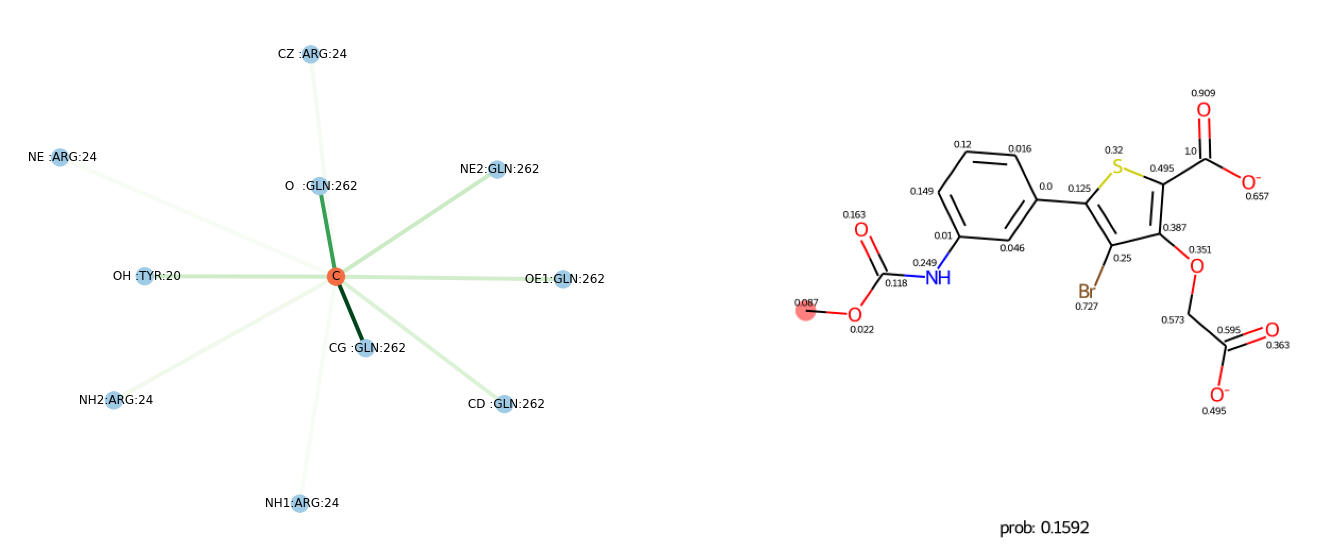

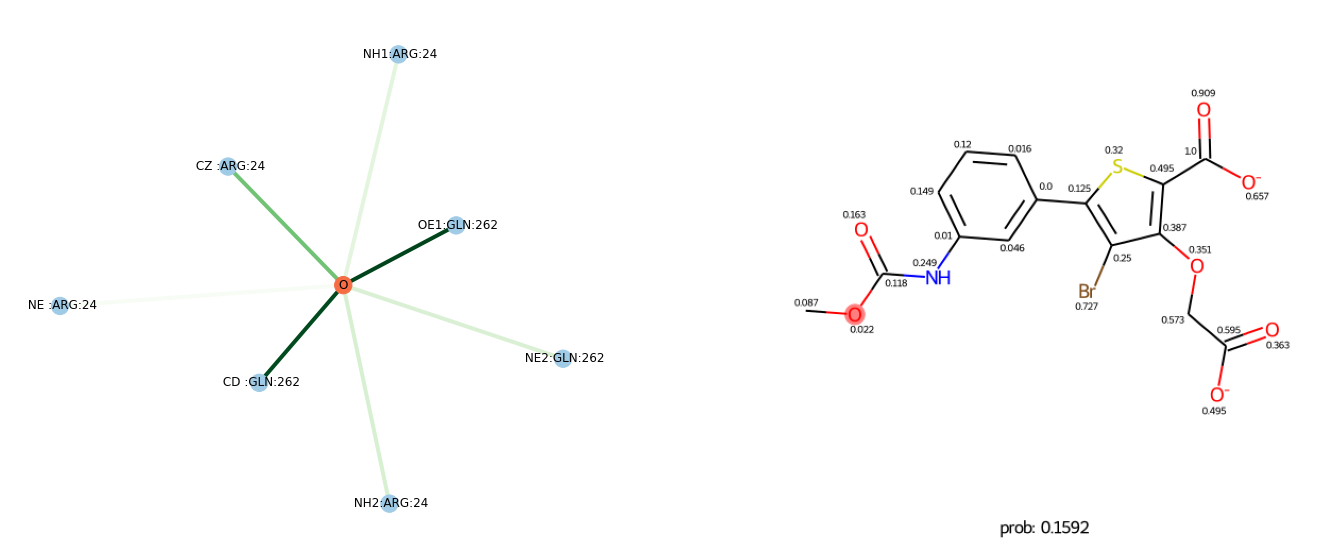

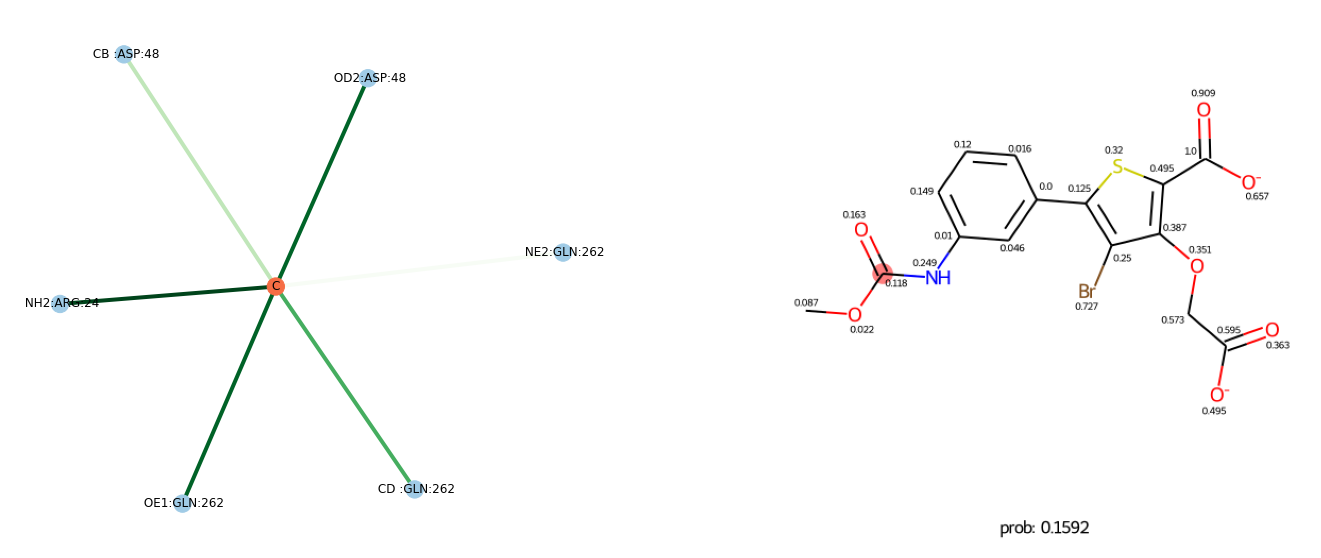

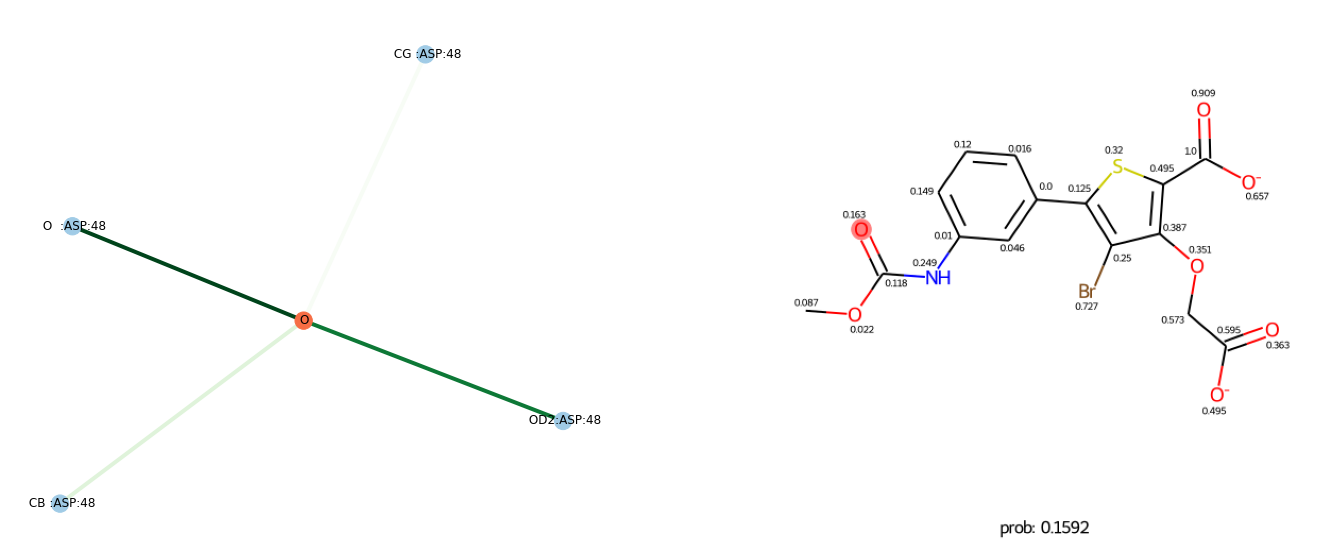

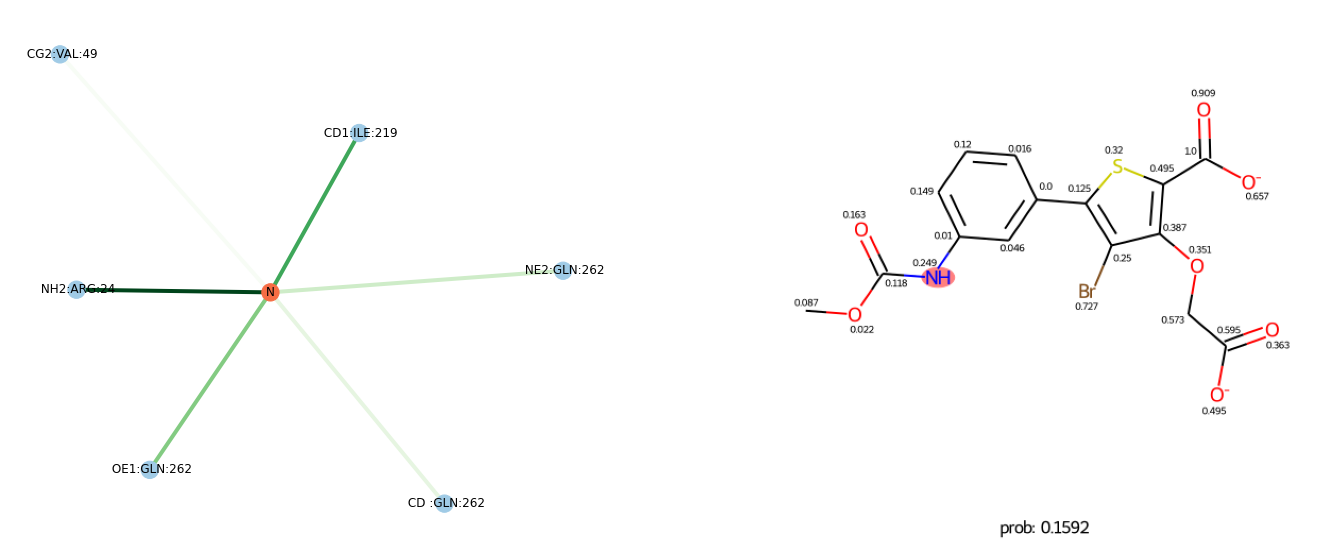

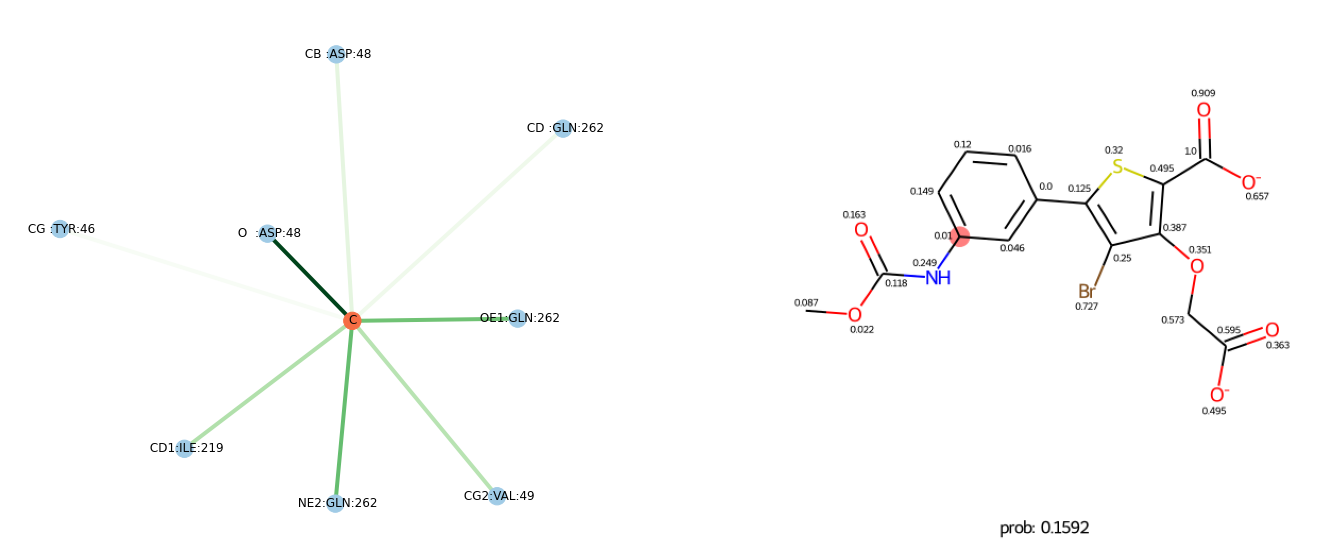

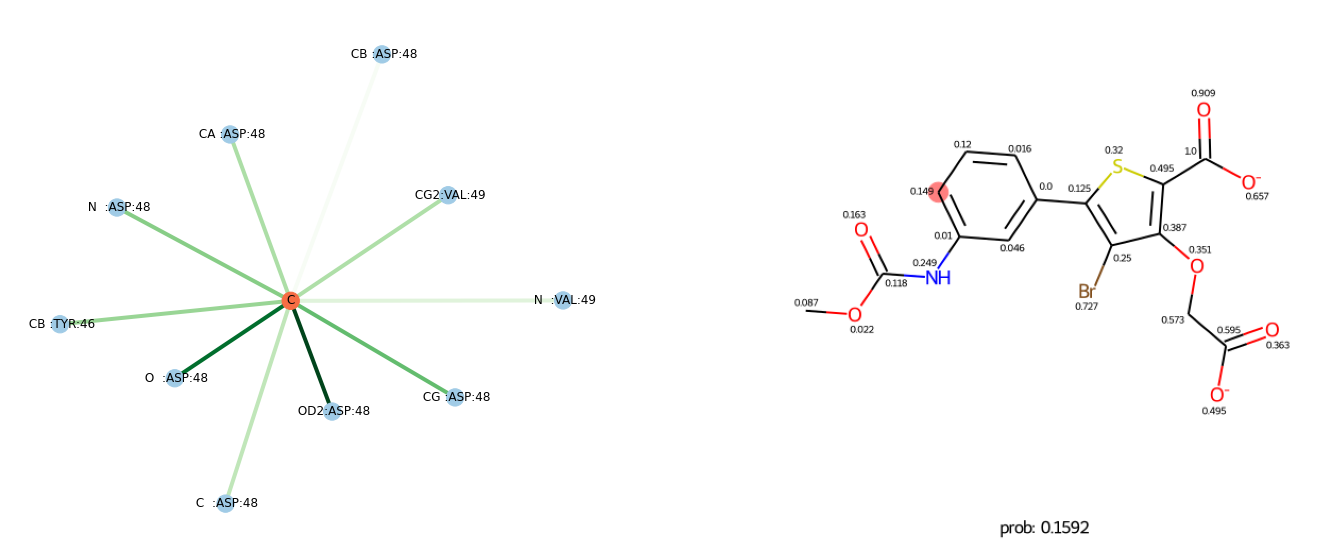

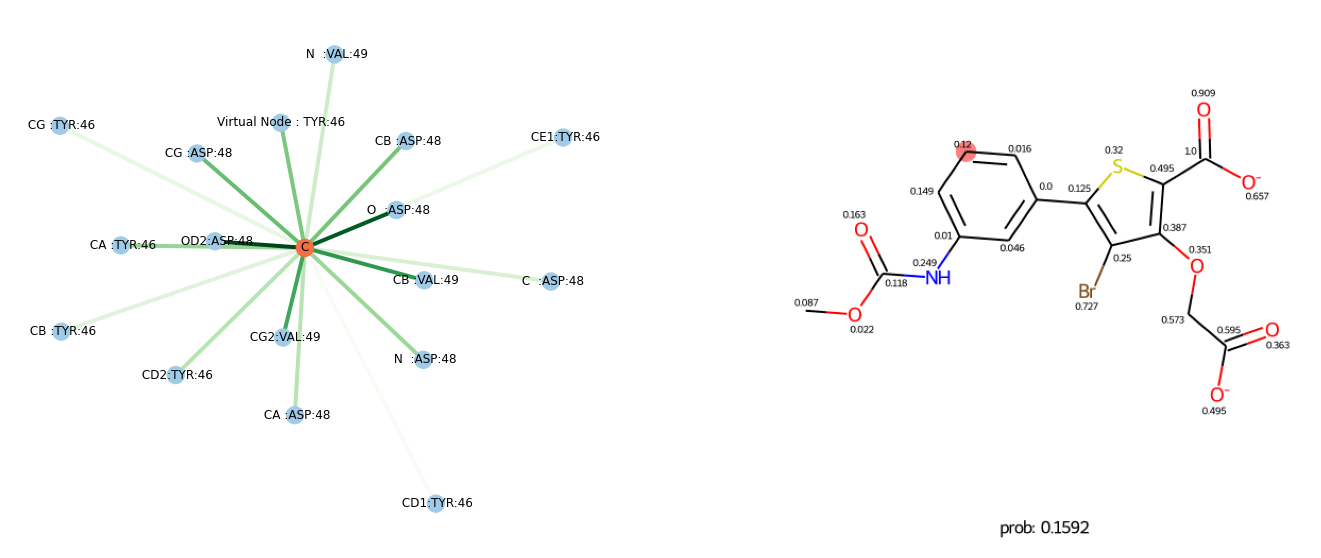

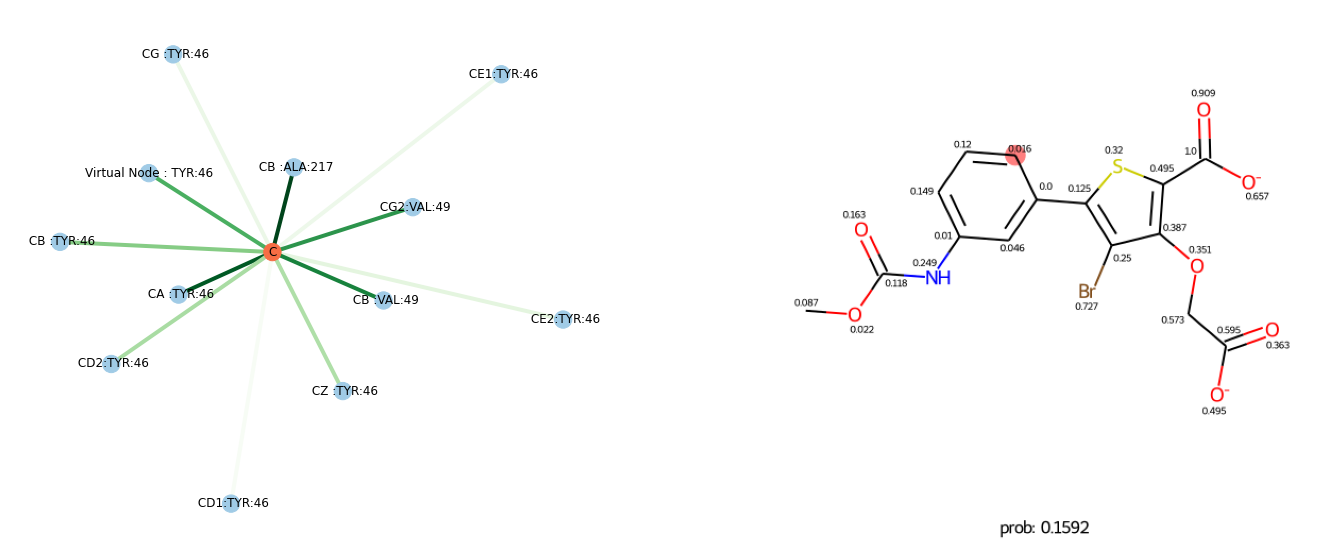

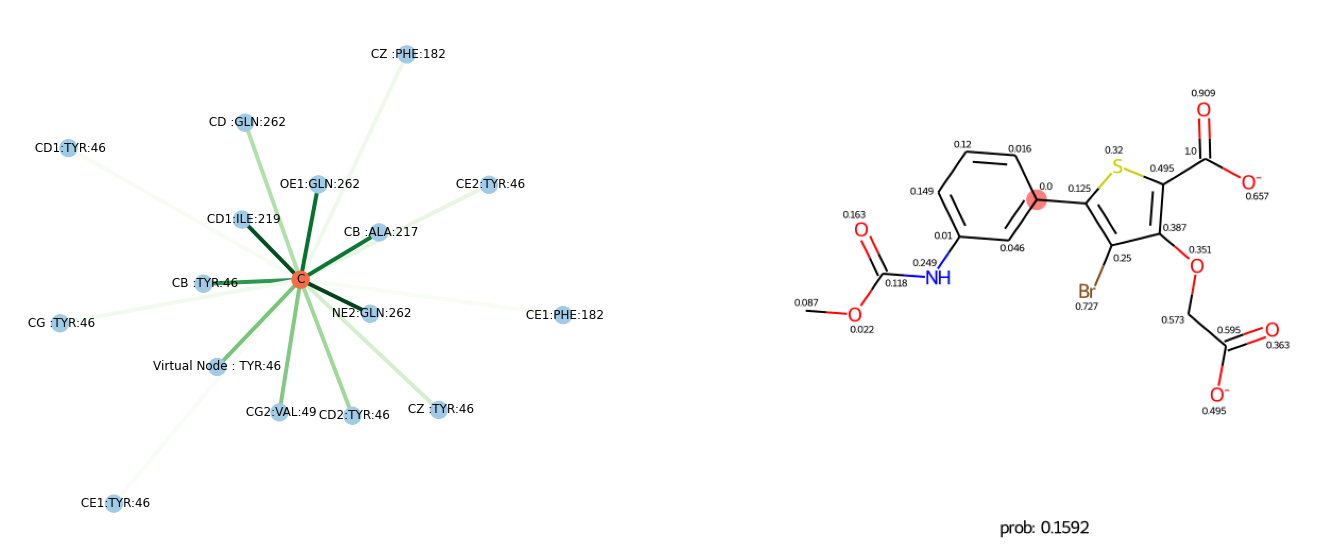

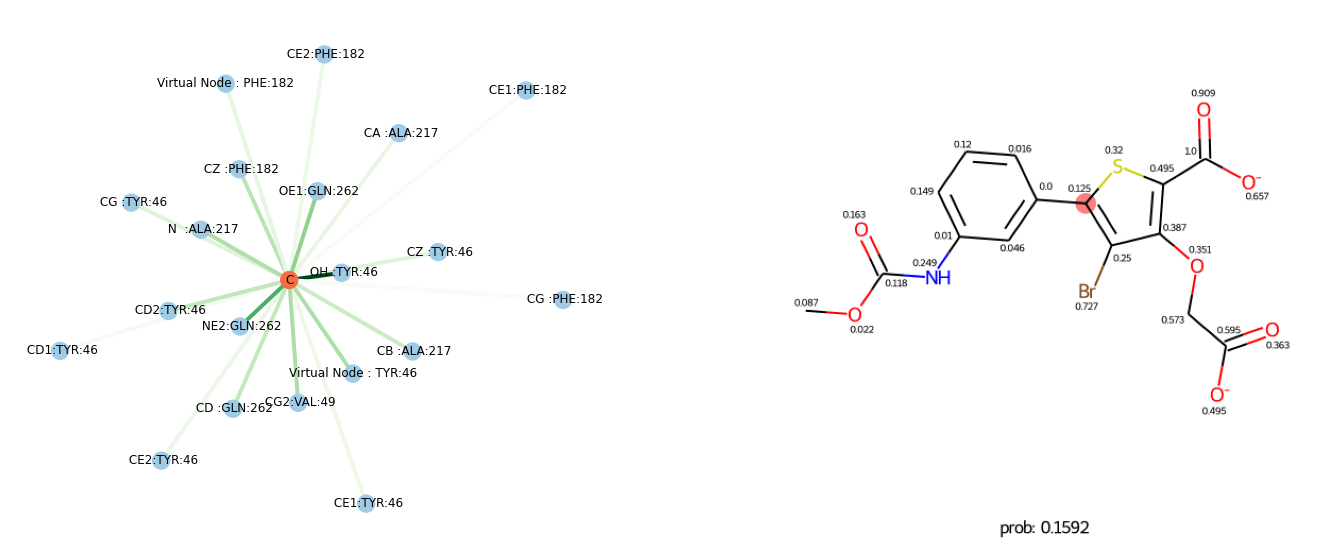

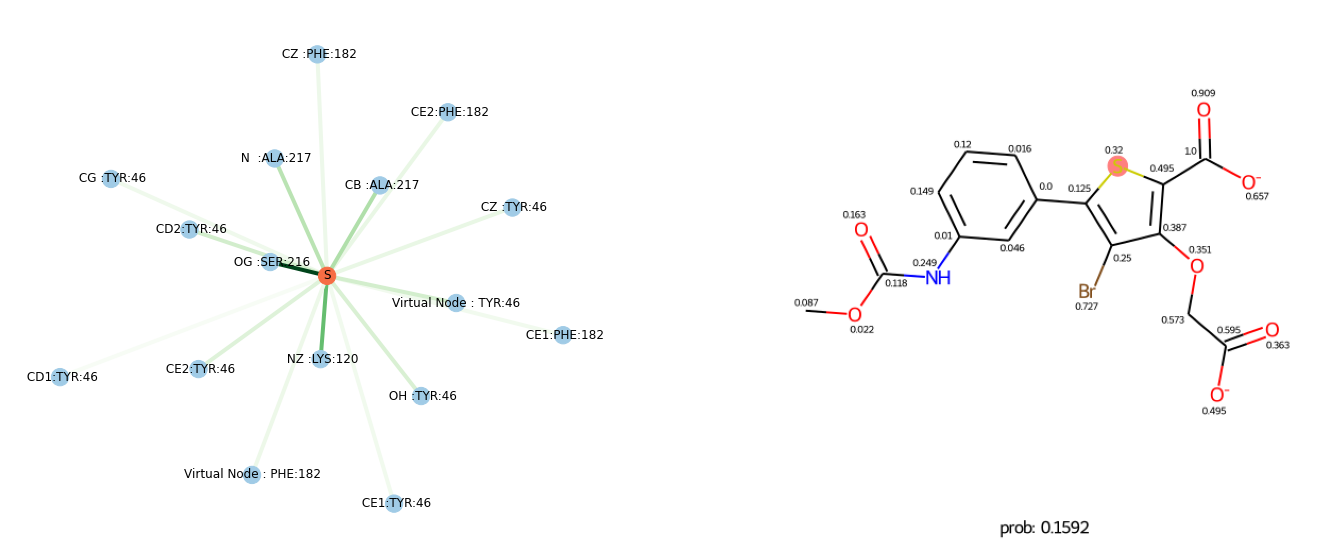

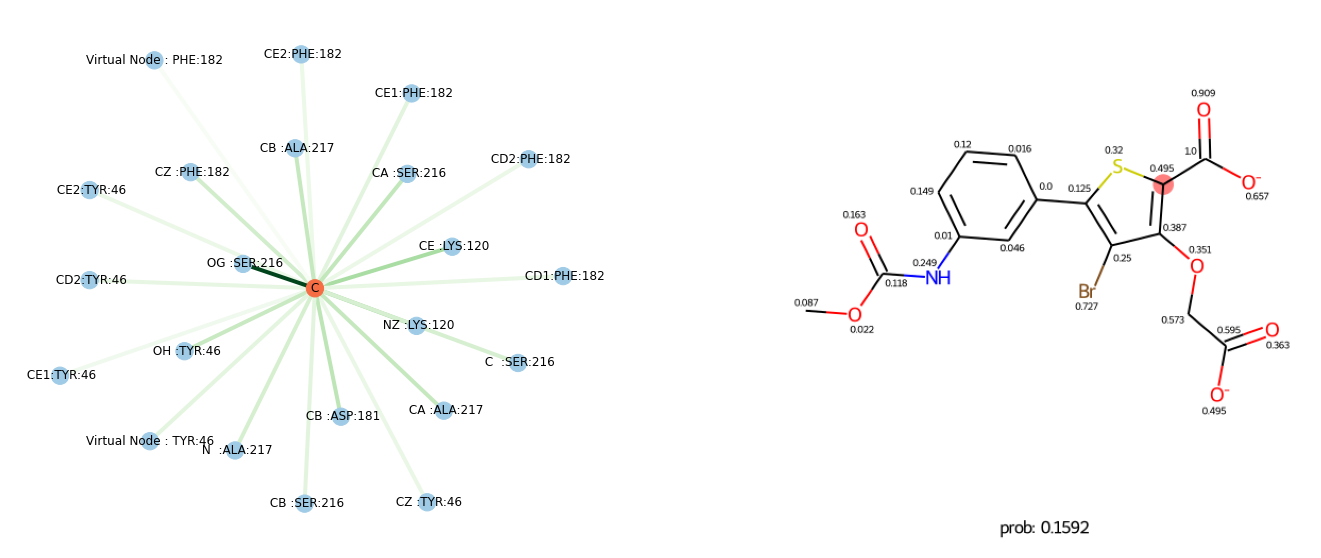

In [12]:
# figure.max_open_warning = 2
add_label = True # set to plot a without label star plot
merge_image_dir = '/figs_merge/target_ptp1b_nolabel/'
for logit,g,key in zip(logits,gs,test_keys):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]
    if logit > 0.0:
        all_atom_ligand = g[0].ndata['V'].sum().cpu().data.numpy()
        true_atom_ligand = len(g[2].GetAtoms())
        true_atom_pocket = len(g[3].GetAtoms())
        inchi_to_mol,mol_to_inchi = InchMap(g[2])
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(g[2]))
        inchi_smiles_to_mol,mol_smiles_to_inchi  = InchMap(mol)

        ligand = g[2]
        pocket = g[3]
        # star_graphs = []
        for idx in range(int(all_atom_ligand)):
            G = nx.Graph()
            if idx < true_atom_ligand:
                ligand_atom = ligand.GetAtomWithIdx(idx).GetSymbol()
            else:
                ligand_atom = f'Virtual Node in ligand No.{idx}'
            G.add_nodes_from([ligand_atom])
            src,dst = g[1].in_edges(torch.tensor([idx]).to('cuda:0'))
            eid = g[1].edge_ids(src,dst)
            data_raw = g[1].edata['score'][eid].cpu().data.numpy()
            data_raw = data_raw.sum(1).flatten()/8
            for weight_idx,src_idx in enumerate(src):
                if src_idx.cpu().data.numpy() >= all_atom_ligand:
                    src_idx = int(src_idx.cpu().data.numpy() - all_atom_ligand)
                    # print(src_idx)
                    if src_idx <true_atom_pocket:
                        atom_pocket,residual_name,residual_num = pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetName(),\
                        pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetResidueName(),pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetResidueNumber()
                        pocket_info = atom_pocket+ ':' + residual_name +':'+ str(residual_num)
                    else:
                        negs = g[0].in_edges(src_idx + int(all_atom_ligand))[0].data.cpu().numpy().tolist()
                        negs = [i - int(all_atom_ligand) for i in negs if i !=idx]
                        residual_name,residual_num = \
                        pocket.GetAtomWithIdx(negs[0]).GetPDBResidueInfo().GetResidueName(),pocket.GetAtomWithIdx(negs[0]).GetPDBResidueInfo().GetResidueNumber()
                        pocket_info = residual_name +':'+ str(residual_num)
                        pocket_info = 'Virtual Node : ' + pocket_info
                    G.add_node(pocket_info)
                    G.add_edge(ligand_atom,pocket_info,weight = data_raw[weight_idx])
            merge_save_path = os.path.join(*[merge_image_dir,os.path.join(*key.split('/')[-2:-1])])
            # print(merge_save_path)
            save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])])
            os.makedirs(merge_save_path, exist_ok=True)
            if idx < true_atom_ligand:
                inchi_idx = inchi_smiles_to_mol[mol_to_inchi[idx]]
                weightmap_dir = os.path.join(save_path,key.split('/')[-1] + '_atom_idx_{}_{}.png'.format(inchi_idx,'%.4f'%logit))
                pltStarWeightMap(G,weightmap_dir,merge_save_path,with_labels=add_label)
            else:
                weightmap_dir = os.path.join(save_path,key.split('/')[-1] +'_virtual_node_{}_{}.png'.format(idx,'%.4f'%logit))
                pltStarWeightMap(G,weightmap_dir,merge_save_path,with_labels=add_label)